# Classification - Word2Vec

This notebook discusses Multi-label classification methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [Word2Vec](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from pathlib import Path
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import Word2VecTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

transformer = Word2VecTransformer.load('word2vec')
train = transformer.fit(X_train)

In [4]:
test = transformer.transform(X_test)

<a id='data_preparation'/>

## Data Preparation

In [3]:
def create_classifier(classifier, name):
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    experimental_classifier.train(train, y_train)
    experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [7]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Classifier not available. Initiating data.
Training: 93.61023545265198s
Test: 0.11493515968322754s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02190670145739197      0.008343409915356712     0.19769850866586056      0.19238814993954054      0.17786961862536227      
micro                                                            0.18491268917345752      0.19010005265929436      0.1874704938155037       
macro                                                            0.08510958400863153      0.08620769209941216      0.085231083962688        


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Classifier not available. Initiating data.
Training: 1.193199634552002s
Test: 144.28073692321777s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013197352510659963     0.05912938331318017      0.3425151148730351       0.196062071745264        0.23232653883802618      
micro                                                            0.5100158144438587       0.1852649719948298       0.2717982933595533       
macro                                                            0.28203012094011376      0.0753454762494167       0.1065976285152256       


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [9]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Classifier not available. Initiating data.
Training: 235.80036568641663s
Test: 0.15699982643127441s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011610768153758035     0.08403869407496976      0.45932083837162435      0.2674042724707779       0.31581102090171015      
micro                                                            0.6665826930343872       0.25333907798362776      0.3671430553628417       
macro                                                            0.45043132801933594      0.1373258482804074       0.18846302932680714      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Classifier not available. Initiating data.
Training: 48.85917353630066s
Test: 1.107938289642334s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011920066187233501     0.07267230955259976      0.3437122128174123       0.18114873035066503      0.22268152242759257      
micro                                                            0.7206212957285919       0.16879697448417827      0.2735241641455279       
macro                                                            0.23747162634976499      0.0590316715272396       0.08255991687752004      


In [11]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Classifier not available. Initiating data.
Training: 41.879276514053345s
Test: 1.2433342933654785s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012137083943231718     0.06844014510278114      0.3206166868198307       0.17024385328496575      0.2085478205792595       
micro                                                            0.6869600987248046       0.15989276652783763      0.2594074016543047       
macro                                                            0.23302737423998124      0.04883774208155985      0.07122389739270575      


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [12]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Classifier not available. Initiating data.
Training: 75.97784614562988s
Test: 3.7133066654205322s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011834786482530389     0.07400241837968562      0.3906187021362354       0.20953446191051997      0.25560689814015086      
micro                                                            0.6936328322918426       0.19661065632629612      0.3063782170831779       
macro                                                            0.2657227946956339       0.07174061443795623      0.09849553015279772      


In [13]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Classifier not available. Initiating data.
Training: 85.27627754211426s
Test: 3.4782581329345703s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.0121014446636543       0.07122128174123338      0.358192261185006        0.1946533655783958       0.23599076793151763      
micro                                                            0.6617190196755264       0.18354157690650583      0.287373983435146        
macro                                                            0.26837081011766073      0.05568041401535245      0.07989260904779569      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [14]:
from skmultilearn.problem_transform import LabelPowerset

#create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

In [15]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [16]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Classifier not available. Initiating data.
Training: 402.8953812122345s
Test: 84.41228175163269s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01284859670336664      0.06372430471584038      0.35215638855300285      0.19885328496573962      0.23701877123279785      
micro                                                            0.5492818924246691       0.18674900665421992      0.27873244971598016      
macro                                                            0.3039533295099303       0.08883417314584668      0.12179712017770322      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [17]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Classifier not available. Initiating data.
Training: 44.07114386558533s
Test: 284.03170347213745s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017060395850569593     0.039419588875453444     0.4080849891389403       0.30346634421604196      0.3111685057731325       
micro                                                            0.33577533577533575      0.2896261190100053       0.31099802092168505      
macro                                                            0.19318816984154127      0.14030477732755034      0.1495181982234289       


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [18]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Classifier not available. Initiating data.
Training: 398.26763439178467s
Test: 139.38508296012878s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012067078215490358     0.067956469165659        0.31531640467553407      0.15984280532043532      0.20004174583981113      
micro                                                            0.7247086247086247       0.14883431471109196      0.24695182493347628      
macro                                                            0.1456054037152857       0.03995949911973998      0.056566049971919004     


In [19]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Classifier not available. Initiating data.
Training: 414.9852764606476s
Test: 161.04745054244995s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011987526252147903     0.07279322853688029      0.34917372027408305      0.18775896815800083      0.22877756664939256      
micro                                                            0.692625258022143        0.1766958686389966       0.2815622854527424       
macro                                                            0.2557018731946992       0.05931483765563497      0.08605142016948257      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [20]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Classifier not available. Initiating data.
Training: 99.04315376281738s
Test: 47.084505796432495s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012104626742187997     0.06928657799274486      0.3111547762998791       0.15874244256348247      0.19805406806011402      
micro                                                            0.7163695299837926       0.14811623342429028      0.24547762615042842      
macro                                                            0.14625891608223596      0.04187684890297825      0.05870507254624181      


In [21]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Classifier not available. Initiating data.
Training: 105.52020359039307s
Test: 42.76086926460266s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011993890409215299     0.07061668681983072      0.35084038694074965      0.18894397420395004      0.23002869426690467      
micro                                                            0.689341983317887        0.17803628704102636      0.2829858469030589       
macro                                                            0.282984218251459        0.06087964787843211      0.08831548888153784      


***Clustering***

In [22]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [23]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [24]:
clusterer_igraph = get_clusterer()

190 labels, 7716 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [25]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Classifier not available. Initiating data.


TypeError: len() of unsized object

In [ ]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [26]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Classifier not available. Initiating data.
Training: 321.05400919914246s
Test: 4.28889012336731s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012019347037484885     0.07049576783555019      0.3553607416364369       0.18591696896412735      0.22905184161532408      
micro                                                            0.6890692845006607       0.17473311312173873      0.2787749178950585       
macro                                                            0.29254828834806557      0.06071326707463295      0.08948170693503184      


In [27]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Classifier not available. Initiating data.
Training: 707.1734745502472s
Test: 3.2514445781707764s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012023801947432062     0.06880290205562273      0.32478839177750907      0.16319226118500604      0.20468215581274835      
micro                                                            0.7303785780240074       0.15146727942936475      0.25090202608937         
macro                                                            0.23170146762391075      0.05341071963866965      0.07686819421015828      


<a id='evaluation'/>

## Evaluation

In [38]:
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
paths = available_classifier_paths('word2vec')

In [39]:
evals = []
paths = [path for path in paths if '-' not in path.name]
for path in paths:
    print(clf)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

ClassifierChain(LinearSVC)
ClassifierChain(LogisticRegression)
DecisionTreeClassifier
KNeighborsClassifier
LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))
LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))
MLARAM
MLkNN
MLPClassifier
MultioutputClassifier(LinearSVC)
MultioutputClassifier(LogisticRegression)
RakelD(LinearSVC)
RakelD(LogisticRegression)
RakelO(LinearSVC)
RakelO(LogisticRegression)


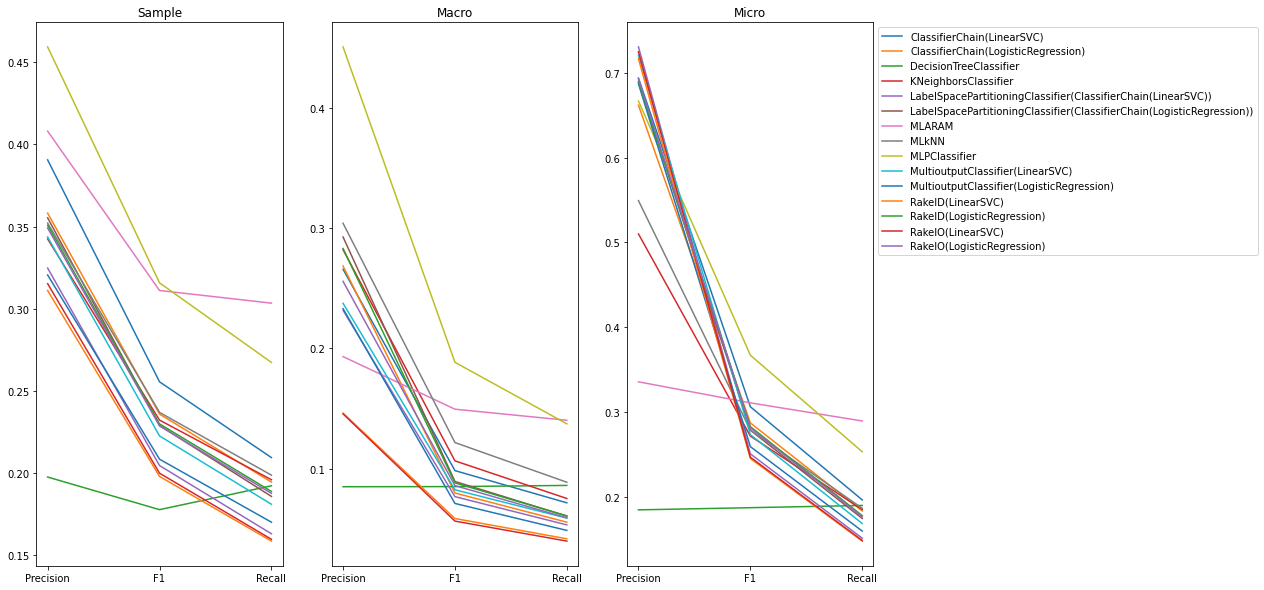

In [40]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [41]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [42]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [44]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

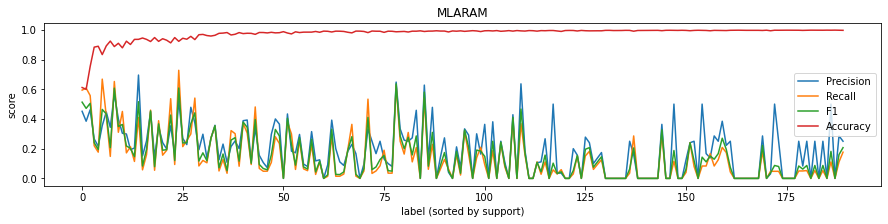

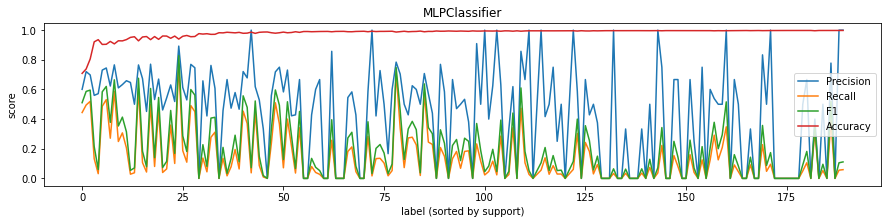

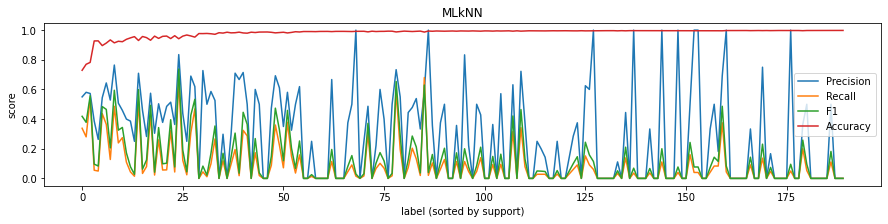

In [45]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [5]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

transformer = Word2VecTransformer.load('word2vec', 100)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Classifier not available. Initiating data.
Training: 44.31480026245117s
Test: 1.042877197265625s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012137083943231718     0.06844014510278114      0.3206166868198307       0.17024385328496575      0.2085478205792595       
micro                                                            0.6869600987248046       0.15989276652783763      0.2594074016543047       
macro                                                            0.23302737423998124      0.04883774208155985      0.07122389739270575      


In [6]:
transformer = Word2VecTransformer.load('word2vec', 200)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Transformer not available. Initiating data.
Classifier not available. Initiating data.
Training: 66.52168154716492s
Test: 2.3287220001220703s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01213326544899128      0.06880290205562273      0.3212313583232567       0.17094518339379283      0.20931594403178438      
micro                                                            0.6870385561936013       0.1603714873857054       0.26004269357655735      
macro                                                            0.23839498222837766      0.04905793940651419      0.07152436180073904      


In [7]:
transformer = Word2VecTransformer.load('word2vec', 500)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Transformer not available. Initiating data.
Classifier not available. Initiating data.
Training: 121.48484349250793s
Test: 4.4582765102386475s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012149175841659771     0.069770253929867        0.3183696090286175       0.16950624748085447      0.2074178038809236       
micro                                                            0.6863476279262481       0.15860022021159462      0.2576606004044175       
macro                                                            0.23013112337317823      0.048263790325105416     0.07028514595608643      


In [8]:
transformer = Word2VecTransformer.load('word2vec', 1000)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Transformer not available. Initiating data.
Classifier not available. Initiating data.
Training: 213.95184636116028s
Test: 8.661784172058105s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012163176987208044     0.06940749697702539      0.31427851672712614      0.1674848851269649       0.2048405021016871       
micro                                                            0.6866204578869985       0.1564938484369764       0.25489278752436645      
macro                                                            0.22279158728360798      0.04696266123148878      0.06836591034788306      


In [16]:
import re
paths = available_classifier_paths('word2vec', 'size')
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        matches = re.findall(r'=([\w,\d]*)', str(path))
        _, _, size = matches
        evals.append([int(size), evaluation])

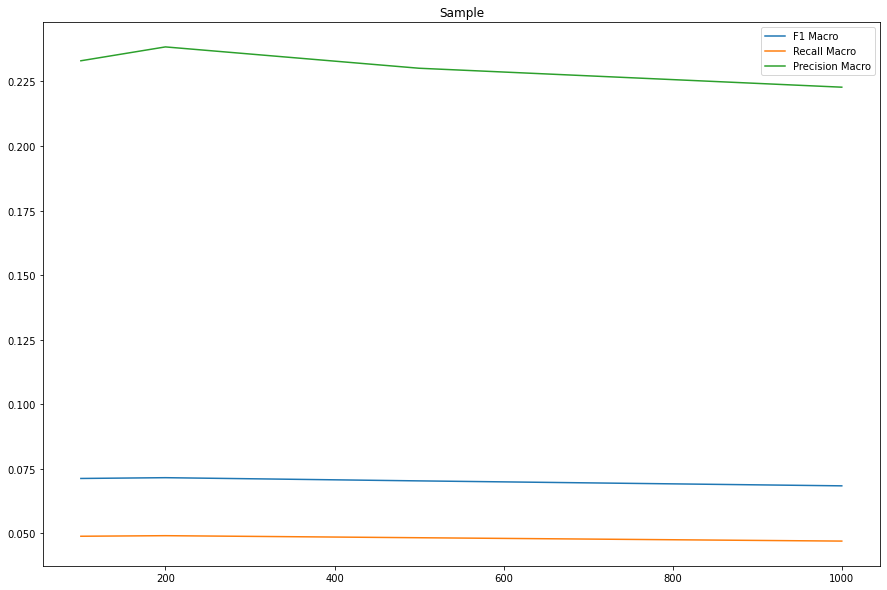

In [17]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()